## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import joblib
import lightgbm as lgb

## Load the Dataset

In [2]:
df = pd.read_csv('dataset_B_05_2020.csv')

# Check the first few rows of the dataset
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


## Check Class Imabalance

Class Distribution:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64

Class Distribution (%):
status
legitimate    50.0
phishing      50.0
Name: proportion, dtype: float64


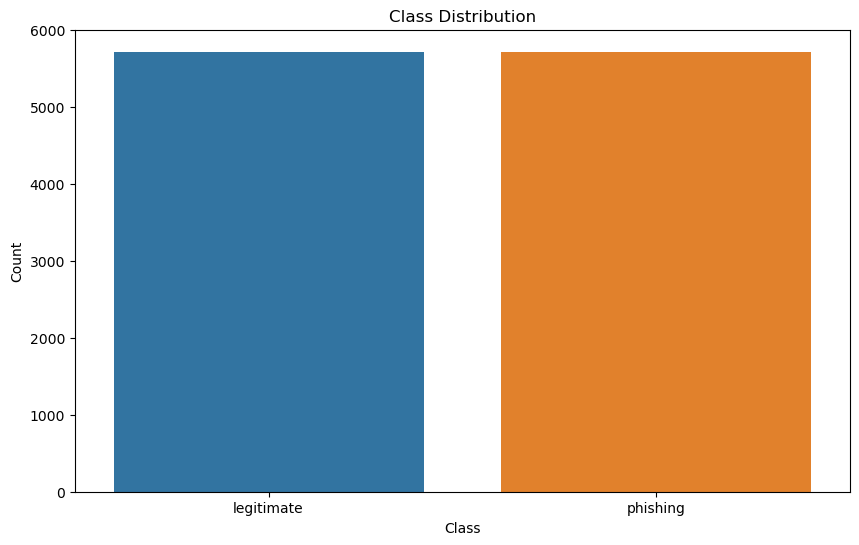


Imbalance Ratio: 1.00


In [3]:
# Check class distribution
target_counts = df['status'].value_counts()
target_percentages = df['status'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(target_counts)
print("\nClass Distribution (%):")
print(target_percentages)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Calculate imbalance ratio
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")


## Handle Class Imbalance

In [4]:
# Check class distribution
print("Class distribution before balancing:")
print(df['status'].value_counts())

# Convert the 'status' column from object (phishing/legitimate) to numeric (1/0)
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

# Verify the mapping
print(df['status'].value_counts())


Class distribution before balancing:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64
status
0    5715
1    5715
Name: count, dtype: int64


In [5]:
# Separate majority (fraudulent) and minority (legitimate) classes
df_majority = df[df['status'] == 1]
df_minority = df[df['status'] == 0]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # match minority class
                                   random_state=42)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Display new class counts
print(df_balanced['status'].value_counts())


status
0    5715
1    5715
Name: count, dtype: int64


## Separate features and target

In [6]:
# Dropping 'status' (target) and 'url' (since it's a textual feature)
x = df_balanced.drop(['status', 'url'], axis=1)
y = df_balanced['status']

# Check the shape of the features and target
print(x.shape, y.shape)


(11430, 87) (11430,)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:
!pip install lightgbm


In [12]:
import lightgbm as lgb
import joblib

# Convert training and testing data to LightGBM dataset
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'is_unbalance': True,  # Handling class imbalance
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
}

# Initialize variables for manual early stopping
best_score = float('inf')
best_iteration = 0
stopping_rounds = 50
stopping_counter = 0

# Train the model manually to implement early stopping
for i in range(1, 1001):  # Set a max iteration of 1000
    model = lgb.train(
        params,
        train_data,
        num_boost_round=i,
        valid_sets=[test_data],  # Validation set
        valid_names=['test']  # Name for the validation set
    )

    # Get the current validation score
    current_score = model.best_score['test']['binary_logloss']
    
    # Print current iteration and score
    print(f"Iteration {i}: Validation score: {current_score}")

    # Check for improvement
    if current_score < best_score:
        best_score = current_score
        best_iteration = i
        stopping_counter = 0  # Reset counter if improvement
    else:
        stopping_counter += 1
    
    # Break if no improvement for stopping_rounds
    if stopping_counter >= stopping_rounds:
        print(f"Early stopping on iteration {i} with best iteration at {best_iteration}.")
        break

# Final model training using the best iteration
final_model = lgb.train(params, train_data, num_boost_round=best_iteration)

# Save the trained model
joblib.dump(final_model, 'optimized_lgbm.joblib')


[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 1: Validation score: 0.6529858691345047
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore

Iteration 19: Validation score: 0.29591368848922467
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 20: Validation score: 0.28612479857161865
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 35: Validation score: 0.18968253096075843
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: 

Iteration 50: Validation score: 0.1440904534978383
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 51: Validation score: 0.14187765844241845
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used 

Iteration 66: Validation score: 0.11683490655006061
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 67: Validation score: 0.11550697007502723
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used

Iteration 82: Validation score: 0.10217730151905609
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 83: Validation score: 0.10156207374055357
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used

Iteration 97: Validation score: 0.09429864922784294
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 98: Validation score: 0.09395152939273117
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used

Iteration 112: Validation score: 0.08924748516243156
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 113: Validation score: 0.08913125108696086
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of us

Iteration 127: Validation score: 0.08535114384557152
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 128: Validation score: 0.08518014775870873
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of us

Iteration 142: Validation score: 0.08228437615638755
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 143: Validation score: 0.08225483042567965
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of us

Iteration 157: Validation score: 0.0804463573844981
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 158: Validation score: 0.08032228621379998
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of use

Iteration 172: Validation score: 0.07924570146041
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 173: Validation score: 0.0790561109025709
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50

Iteration 187: Validation score: 0.07824334393977207
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 188: Validation score: 0.078233692191634
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

Iteration 202: Validation score: 0.07738115727771247
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 203: Validation score: 0.07723555896871463
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of us

Iteration 217: Validation score: 0.07701774067861147
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 218: Validation score: 0.07691374013717765
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of us

Iteration 232: Validation score: 0.0763608405768054
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 233: Validation score: 0.07625933293675048
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of use

Iteration 247: Validation score: 0.0763975217809811
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 248: Validation score: 0.07634345705488517
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [I

Iteration 262: Validation score: 0.07641933896481412
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 263: Validation score: 0.0763474724627705
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

Iteration 277: Validation score: 0.07623184844086477
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 278: Validation score: 0.07623301792883054
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

Iteration 292: Validation score: 0.07640797703442408
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 293: Validation score: 0.07639573911301595
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

Iteration 306: Validation score: 0.07654745841744554
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 307: Validation score: 0.07661209442098699
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [

Iteration 321: Validation score: 0.07687566754254337
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005249
[LightGBM] [Info] Start training from score 0.005249
Iteration 322: Validation score: 0.07685933295791153
[LightGBM] [Info] Number of positive: 4584, number of negative: 4560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4965
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

['optimized_lgbm.joblib']

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1155
           1       0.97      0.98      0.98      1131

    accuracy                           0.98      2286
   macro avg       0.98      0.98      0.98      2286
weighted avg       0.98      0.98      0.98      2286

[[1122   33]
 [  21 1110]]


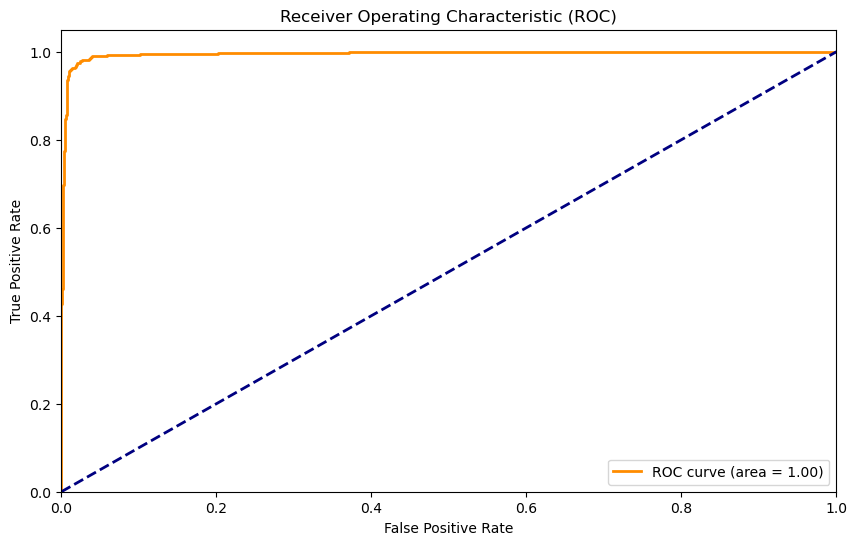

In [13]:
# Predictions
y_pred = model.predict(x_test)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Classification report
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [14]:
# Tune the threshold for predictions
new_threshold = 0.6  # You can adjust this value
y_pred_binary_adjusted = np.where(y_pred > new_threshold, 1, 0)

# Re-evaluate
print(classification_report(y_test, y_pred_binary_adjusted))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1155
           1       0.98      0.98      0.98      1131

    accuracy                           0.98      2286
   macro avg       0.98      0.98      0.98      2286
weighted avg       0.98      0.98      0.98      2286

